In [1]:

using Pkg
Pkg.activate("./baron_env")
#Pkg.pin("JuMP")
using JuMP
using CSV
using GraphRecipes, Plots
using LightGraphs
using LinearAlgebra
using SparseArrays
using DataFrames


  Activating environment at `~/Documents/project-codes/Plan_RoadmapsIAM/toy-problem/baron_env/Project.toml`


In [3]:
innovations = CSV.File("./data-case-roadmap/innovations.csv",header=1,delim=",") |> DataFrame
#innovations = CSV.File("./data/innovations_append.csv",header=1,delim=",") |> DataFrame
mapki = CSV.File("./data-case-roadmap/map-ki.csv",header=1,delim=",") |> DataFrame
compromise = CSV.File("./data-case-roadmap/compromise.csv",header=1,delim=",") |> DataFrame
initial = CSV.File("./data-case-roadmap/initial.csv",header=1,delim=",") |> DataFrame
ci=innovations[!,2]
rl=innovations[!,3]
initial
#innovations[2,6]=7
#compromise[!,3]=compromise[!,3]/2
#innovations[2,2]=175
#innovations[2,3]=2
#innovations[1,3]=3
#innovations[4,2]=168
#innovations[3,3]=2
innovations

,i,Cost_per_RL,RL,Sojourn1,Sojourn2,Sojourn3,Sojourn4,Sojourn5,P11
,Int64,Float64,Int64,Float64,Float64,Float64,Float64,Float64,Int64
1,1,121.08,3,8.32,8.84,0.65,9.9,9.65,0
2,2,103.22,3,8.32,8.84,0.65,9.9,9.65,0
3,3,85.84,1,4.6,1.34,2.04,0.12,8.86,0
4,4,90.68,1,5.48,7.62,3.34,5.05,1.1,0
5,5,77.52,3,9.94,2.38,7.94,3.82,5.44,0
6,6,98.51,2,4.44,1.21,5.09,6.52,8.67,0
7,7,121.59,3,4.44,1.21,5.09,6.52,8.67,0
8,8,122.1,1,4.6,1.34,2.04,0.12,8.86,0
9,9,122.26,2,5.48,7.62,3.34,5.05,1.1,0


In [4]:
function get_transition_mat(i)
    p_mat=reshape(collect(innovations[i,9:33]),5,5)
    return p_mat'
end


function get_rate_mat(i)
    p_mat=get_transition_mat(i)
    q_mat=p_mat./collect(innovations[i,4:8])
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    return q_mat
end

function get_rate_eig_mat(i)
    p_mat=get_transition_mat(i)
    q_mat=p_mat./collect(innovations[i,4:8])
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    return [q_mat,eigvecs(q_mat),eigvals(q_mat)]
end

function get_IAM_factor(t)
    return 1
end

function give_sorted(t)
    v=sortperm(t)
    return v
end


function calc_tot_co2(x,t)
    v=give_sorted(t)
    for i in 1:(size(tk)[1]-1)
        print(initial[1,3]*tk[v][1]-sum(xk[v[j]]*tk[v][j+1]*(initial[1,3]-compromise[v,3][j]) for j in 1:i))
        print("\n")
    end
    return 1
end

function get_RL_atT(i,t)
    s0=[0 0 0 0 0]
    s0[rl[i]]=1
    q=get_rate_mat(i)
    #rl_t=sum([1 2 3 4 5].*(s0*exp(q*t)))
    #rl_t=sum([1 2 3 4 5].*(s0*(I+t*q+1/2*t^2*q^2)))
    temp1=Diagonal(eigvals(q))*t
    temp2=reshape(reduce(vcat,(exp(temp1))),5,5)
    d=eigvecs(q)*(temp2)*inv(eigvecs(q))
    rl_t=sum([1 2 3 4 5].*(s0*d))
    return rl_t
end

function get_RL(i,t)
    s0=[0 0 0 0 0]
    s0[rl[i]]=1
    p_mat=reshape(collect(innovations[i,9:33]),5,5)'
    q_mat=p_mat./collect(innovations[i,4:8])
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    q=q_mat
    #rl_t=sum([1 2 3 4 5].*(s0*exp(q*t)))
    #rl_t=sum([1 2 3 4 5].*(s0*(I+t*q+1/2*t^2*q^2)))
    temp1=Diagonal(eigvals(q))*t
    temp2=reshape(reduce(vcat,(exp(temp1))),5,5)
    d=eigvecs(q)*(temp2)*inv(eigvecs(q))
    rl_t=sum([1 2 3 4 5].*(s0*d))
    return rl_t
end

function get_RL_DTMC(i,t)
    s0=[0 0 0 0 0]
    s0[rl[i]]=1
    p_mat=reshape(collect(innovations[i,9:33]),5,5)'
    rl_t=sum([1 2 3 4 5].*(s0*p_mat^t))
    return rl_t
end
    



get_RL_DTMC (generic function with 1 method)

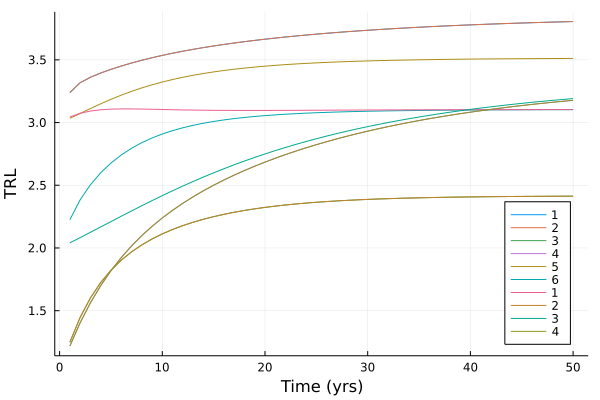

In [5]:
get_RL_atT(4,25)
pal = palette(:default)
plot([get_RL_atT.(i, 1:50) for i = 1:nrow(innovations)]; color = [pal[i] for i = 1:nrow(innovations)]',label=[1;2;3;4;5;6]', legend=:bottomright,ylab="TRL", xlab="Time (yrs)")
#plot_ref=plot!(range(1, 50; length = 20), [get_RL_DTMC.(i, 1:20) for i = 1:5], linestyle = :dot, color = pal[1:5]', labels=[1,2,3,4,5]') 
#savefig(plot_ref,"evolution-inn_ctmc.svg")

In [6]:
### iam_model=DataFrame()
#zero is 2020 SSP2-34 IMAGE 3.0.1

#iam_model[!,"Yr"]=[0;10;20;30;40;50]
#iam_model[!,"Back_RedFr_Elec"]=[1
#0.949784976
#0.809145552
#0.623734704
#0.41470694
#0.331447018]

iam_model = CSV.File("./data/iam_model.csv",header=1,delim=",") |> DataFrame
iam_model


#CSV.write("./data/iam_model.csv",iam_model)

,Yr,Back_RedFr_Elec
,Int64,Float64
1,0,1.0
2,10,0.949785
3,20,0.809146
4,30,0.623735
5,40,0.414707
6,50,0.331447


In [7]:
compromise

,k,i,GWP,Theta,Per_Recycl,Per_Comp,GHG_ElecInd,GHG_Trans,OCost
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,1,15.0711,0.621,0.0,0.0,0.499,0.122,3.4294
2,2,1,2.7837,0.3955,0.661676,0.0,0.47,0.127,1.1203
3,3,1,10.0834,0.41,0.0,1.0,0.56,0.111,0.65
4,4,1,8.9103,0.4132,0.0,0.958953,0.54,0.104,0.67
5,5,1,4.0,0.4546,0.0,0.0,0.54,0.139,0.7
6,6,1,4.1434,0.5081,0.0,0.0,0.57,0.12,0.7
7,7,1,7.1535,0.4218,0.0,0.854318,0.5,0.114,0.7
8,8,1,4.1374,0.5081,0.0,0.0,0.46,0.116,0.7
9,9,1,7.1535,0.4218,0.0,0.854318,0.52,0.132,0.7


In [8]:
function get_transition_mat(i)
    p_mat=reshape(collect(innovations[i,9:33]),5,5)
    return p_mat'
end


function get_rate_mat(i)
    p_mat=get_transition_mat(i)
    q_mat=p_mat./collect(innovations[i,4:8])
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    return q_mat
end

function get_rate_eig_mat(i)
    p_mat=get_transition_mat(i)
    q_mat=p_mat./collect(innovations[i,4:8])
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    return [q_mat,eigvecs(q_mat),eigvals(q_mat)]
end

function get_IAM_factor(t)
    return 1
end

function give_sorted(t)
    v=sortperm(t)
    return v
end


function calc_tot_co2(x,t)
    v=give_sorted(t)
    for i in 1:(size(tk)[1]-1)
        print(initial[1,3]*tk[v][1]-sum(xk[v[j]]*tk[v][j+1]*(initial[1,3]-compromise[v,3][j]) for j in 1:i))
        print("\n")
    end
    return 1
end

function get_RL_atT(i,t)
    s0=[0 0 0 0 0]
    s0[rl[i]]=1
    q=get_rate_mat(i)
    #rl_t=sum([1 2 3 4 5].*(s0*exp(q*t)))
    #rl_t=sum([1 2 3 4 5].*(s0*(I+t*q+1/2*t^2*q^2)))
    temp1=Diagonal(eigvals(q))*t
    temp2=reshape(reduce(vcat,(exp(temp1))),5,5)
    d=eigvecs(q)*(temp2)*inv(eigvecs(q))
    rl_t=sum([1 2 3 4 5].*(s0*d))
    return rl_t
end

function get_RL(i,t)
    s0=[0 0 0 0 0]
    s0[rl[i]]=1
    p_mat=reshape(collect(innovations[i,9:33]),5,5)'
    q_mat=p_mat./collect(innovations[i,4:8])
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    q=q_mat
    #rl_t=sum([1 2 3 4 5].*(s0*exp(q*t)))
    #rl_t=sum([1 2 3 4 5].*(s0*(I+t*q+1/2*t^2*q^2)))
    temp1=Diagonal(eigvals(q))*t
    temp2=reshape(reduce(vcat,(exp(temp1))),5,5)
    d=eigvecs(q)*(temp2)*inv(eigvecs(q))
    rl_t=sum([1 2 3 4 5].*(s0*d))
    return rl_t
end

function get_RL_DTMC(i,t)
    s0=[0 0 0 0 0]
    s0[rl[i]]=1
    p_mat=reshape(collect(innovations[i,9:33]),5,5)'
    rl_t=sum([1 2 3 4 5].*(s0*p_mat^t))
    return rl_t
end
    



get_RL_DTMC (generic function with 1 method)

## Additional functions

In [19]:
q=zeros(5,5,nrow(innovations))
a=zeros(5,5,nrow(innovations))
ainv=zeros(5,5,nrow(innovations))
d=zeros(5,1,nrow(innovations))
s0=zeros(1,5,nrow(innovations))
for i in 1:nrow(innovations)
    q[:,:,i]=round.(get_rate_eig_mat(i)[1],sigdigits=3)
    a[:,:,i]=(get_rate_eig_mat(i)[2])
    d[:,:,i]=round.(get_rate_eig_mat(i)[3],sigdigits=3)
    ainv[:,:,i]=round.(inv(get_rate_eig_mat(i)[2]),sigdigits=3)
    s0[1,rl[i],i]=1
end
rl_vals=[1 2 3 4 5]

function get_latest(i,t)
    e0=zeros(5,1,i)
    e1=zeros(5,5,i)
    e2=zeros(5,5,i)
    e3=zeros(1,5,i)
    for r in 1:5
        e0[r,1,i]=exp(d[r,1,i]*t)
    end

    for r in 1:5
        for c in 1:5
            e1[r,c,i]=e0[r,1,i]*ainv[r,c,i]
        end
    end

    for r in 1:5
        for c in 1:5
            e2[r,c,i]=sum(a[r,c1,i]*e1[c1,c,i] for c1 in 1:5)
        end
    end

    for c in 1:5
        e3[1,c,i]=sum(s0[1,r,i]*e2[r,c,i] for r in 1:5)
    end


    e4=sum(rl_vals[c]*e3[1,c,i] for c in 1:5)

    #rl_vals*([0 1 0 0 0]*a[:,:,1]*Diagonal(round.(exp.(get_new2(1,t)),sigdigits=3))*get_new3(1,t))'
    return 5-e4
end

get_latest(9,50)
#rl_vals*([0 1 0 0 0]*a[:,:,1]*Diagonal(round.(exp.(get_new2(1,t)),sigdigits=3))*get_new3(1,t))'

1.8132172889071705

In [10]:
innovations

,i,Cost_per_RL,RL,Sojourn1,Sojourn2,Sojourn3,Sojourn4,Sojourn5,P11
,Int64,Float64,Int64,Float64,Float64,Float64,Float64,Float64,Int64
1,1,121.08,3,8.32,8.84,0.65,9.9,9.65,0
2,2,103.22,3,8.32,8.84,0.65,9.9,9.65,0
3,3,85.84,1,4.6,1.34,2.04,0.12,8.86,0
4,4,90.68,1,5.48,7.62,3.34,5.05,1.1,0
5,5,77.52,3,9.94,2.38,7.94,3.82,5.44,0
6,6,98.51,2,4.44,1.21,5.09,6.52,8.67,0
7,7,121.59,3,4.44,1.21,5.09,6.52,8.67,0
8,8,122.1,1,4.6,1.34,2.04,0.12,8.86,0
9,9,122.26,2,5.48,7.62,3.34,5.05,1.1,0


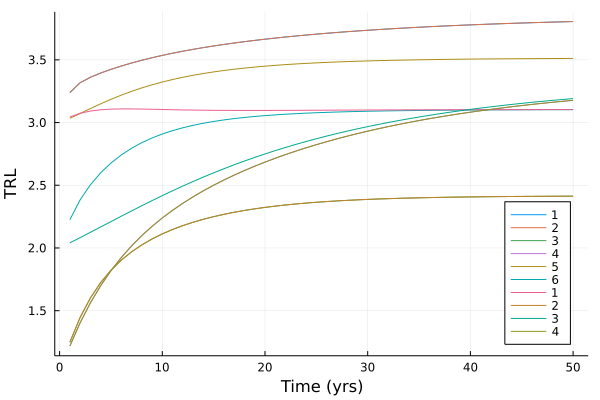

In [20]:
get_RL_atT(4,25)
pal = palette(:default)
plot([get_RL_atT.(i, 1:50) for i = 1:nrow(innovations)]; color = [pal[i] for i = 1:nrow(innovations)]',label=[1;2;3;4;5;6]', legend=:bottomright,ylab="TRL", xlab="Time (yrs)")
#plot_ref=plot!(range(1, 50; length = 20), [get_RL_DTMC.(i, 1:20) for i = 1:5], linestyle = :dot, color = pal[1:5]', labels=[1,2,3,4,5]') 
#savefig(plot_ref,"evolution-inn_ctmc.svg")

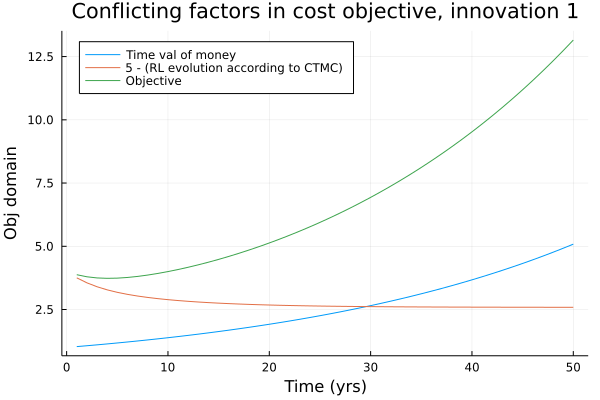

In [22]:
inn=8
plot(range(1, 50; length = 50),[0.968^(-1*i) for i = 1:50],labels="Time val of money")
plot!(range(1, 50; length = 50), [get_latest.(inn,1:50)],labels="5 - (RL evolution according to CTMC)")
plot_ref=plot!(range(1, 50; length = 50), [0.968^(-1*i)*get_latest.(inn,i) for i = 1:50], labels="Objective",legend=:topleft,
        xlab="Time (yrs)", ylab="Obj domain", title="Conflicting factors in cost objective, innovation 1")
#savefig(plot_ref,"evolution-inn_costObj.svg")

In [23]:
intvls=40
fval=zeros(intvls+1,nrow(innovations))
tval=zeros(intvls+1,nrow(innovations))
for inn in 1:10
    tval[:,inn]=[i*(50/intvls) for i = 0:intvls]
    fval[:,inn]=[0.968^(-1*i*(50/intvls))*get_latest.(inn,i*(50/intvls)) for i =0:intvls]
end
[tval[:,1] fval]

41×11 Matrix{Float64}:
  0.0   2.00531  2.00531   3.99954  …  1.99187   3.99954  3.00544  4.00328
  1.25  1.81274  1.81274   3.85163     2.02215   3.85163  3.07645  3.89177
  2.5   1.80563  1.80563   3.76685     2.07532   3.76685  3.14709  3.81642
  3.75  1.82971  1.82971   3.734       2.14504   3.734    3.21751  3.77058
  5.0   1.86237  1.86237   3.74025     2.22677   3.74025  3.28807  3.74879
  6.25  1.90007  1.90007   3.77567  …  2.31737   3.77567  3.35925  3.74672
  7.5   1.94212  1.94212   3.8334      2.41481   3.8334   3.43158  3.761
  8.75  1.98825  1.98825   3.90896     2.51779   3.90896  3.50562  3.78902
 10.0   2.03832  2.03832   3.99942     2.62557   3.99942  3.58187  3.82875
 11.25  2.09223  2.09223   4.1029      2.73773   4.1029   3.66082  3.87867
 12.5   2.14992  2.14992   4.2182   …  2.85416   4.2182   3.74289  3.93761
 13.75  2.21136  2.21136   4.34455     2.97486   4.34455  3.82851  4.00472
 15.0   2.27655  2.27655   4.48148     3.09997   4.48148  3.91802  4.07937
  ⋮ 

In [24]:
#CSV.write("./data-case-roadmap/cost_inn_obj.csv",  Tables.table([tval[:,1] fval]), writeheader=true)


"./data-case-roadmap/cost_inn_obj.csv"

In [25]:
g=exp(get_rate_mat(2)*50)


5×5 Matrix{Float64}:
 0.101512   0.169556   0.0210212  0.456686  0.251225
 0.0929036  0.156056   0.0205987  0.468088  0.262354
 0.0726662  0.123311   0.0195651  0.495131  0.289326
 0.0616718  0.105597   0.0190067  0.509809  0.303915
 0.0574321  0.0987494  0.0187847  0.515269  0.309765

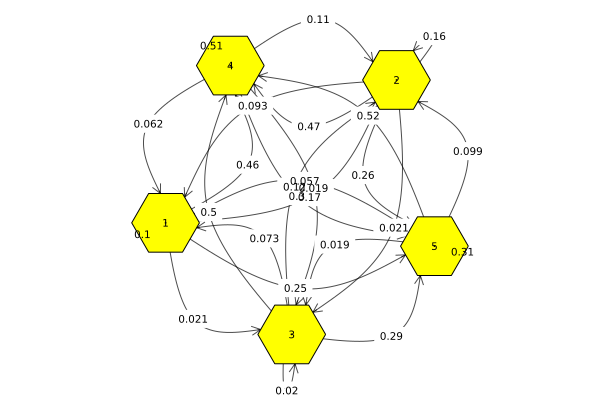

In [26]:
n = 5
edgelabel_dict = Dict()
edgelabel_mat = Array{String}(undef, n, n)
for i in 1:n
    for j in 1:n
        edgelabel_mat[i, j] = edgelabel_dict[(i, j)] = string(round(g[i,j],sigdigits=2)) 
    end
end
edgelabel_vec = edgelabel_mat[:]


graphplot(g, names=1:5, curvature_scalar=0.2,  edgelabel=edgelabel_dict, markersize = 0.5,
           linecolor = :darkgrey, markercolor = "yellow",
           linealpha = 0.7)